In [2]:
import sys
sys.path.append('/users/stan/documents/')
import os
from glob import glob
import copy
import pandas
import numpy as np

from d_code.imaging.io import tifffile
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from collections import defaultdict
from scipy import signal
from time import time
import cPickle as pickle
import spUtils
import seaborn as sns


import graphlab as gl
gl.canvas.set_target('ipynb')
import pandas as pd

sns.set_palette("husl")
sns.set_style("white")
sns.set_context("poster")


%matplotlib inline
#style notebook
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())


/Users/Stan/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1499300463.log


This non-commercial license of GraphLab Create for academic use is assigned to stanlp86@gmail.com and will expire on November 04, 2017.


In [19]:
experiment = 'sp062817a'
#slice_ = 1
epoch_ = 1

basedir = '/Users/Stan/Desktop/'# '/Volumes/G-DRIVE PRO Thunderbolt/2017/' # '/Users/Stan/Desktop/'

h5dir = basedir + 'h5/'
qcGitDir = '/Users/Stan/Documents/myPiriform/notebooks/qc/{0}/'.format(experiment)
odorInfoPath = basedir + '{0}/odorInfo_e1.dat'.format(experiment)
odorNames = pd.DataFrame.from_csv(basedir + '{}/e1_odor_order_odorlist.csv'.format(experiment))
odorNames.index.name = 'odorID'

# classes = dict(esters = [1,2,3,4,5],
#                 aldehydes = [6,7,8,9,10],
#                 ketones = [11,12,13,14,15,16],
#                 acids = [17,18,19,20,21,22])

odor_info = pickle.load(open(odorInfoPath))['epoch1']

for slice_ in [2]:

    sframePath = basedir + '{0}/sframe_slice_{1}_processed'.format(experiment, slice_)
    tifPath = basedir + '{0}/aligned/green/slice_{1}/'.format(experiment, slice_)
    workflowDictPath = basedir + '{0}/workflow_dict_e1_slice{1}.dat'.format(experiment, slice_)
    
    metadataPath = basedir + '{0}/metadata/slice_{1}/{0}_e1_002_015_slice_{1}_channel_0.dat'.format(experiment, slice_)
    

    epochID = 1
    sliceID = slice_
    sframe = gl.SFrame(sframePath)
    good_trials = [1,2,3,4,5,6,7]

    sframe['slice'] = sliceID
    df = sframe[(sframe['epoch']==epochID) &(sframe['slice']==sliceID)&(sframe['cellProbBinary']==1)]['Frame', 'RoiSignal', 'cellID','redLabel', 'trial', 'odorPos', 'odorID', 'odorOn', 'odorOff', 'normed_traces', 'normed_stds', 'baselined1_traces', 'slice'].to_dataframe()
    df = df.loc[df.trial.isin(good_trials)]
    #inh neurons only
    #df = df.loc[df.redLabel==1]
    epoch = df.groupby(['trial', 'cellID']).apply(lambda x: x.reset_index(drop = True))

    # get dimensions 
    #frames, cells, trials = [epoch.loc[(10,1)]['RoiSignal'].size] + [epoch[_].unique().shape[0] for _ in ['cellID','trial']]
    numOdors = 23

    epoch = epoch.loc[epoch.Frame<233]

    trialSet = epoch.trial.unique()
    cells = epoch.index.get_level_values('cellID').unique().shape[0]
    frames =  epoch.Frame.unique().shape[0]*numOdors
    trials = len(good_trials)
    
    
    workflow_dict = defaultdict(dict)

    trialIDList = []
    for trial in odor_info:
        trialIDList.append(trial['trialID'])

    odor_info = pickle.load(open(odorInfoPath))['epoch1']

    trialIDList = []
    for trial in odor_info:
        trialIDList.append(trial['trialID'])

    workflow_dict['odor_info']= odor_info

    traces = np.empty((trials,cells,frames))
    for itrial, trialID in enumerate(trialIDList):
        traces[itrial,:,:] = epoch.loc[trialID, 'RoiSignal'].unstack('cellID').T
    traces = traces.T
    workflow_dict['raw_traces'] = traces

    normed_traces = np.empty((trials, cells, frames))
    for itrial, trialID in enumerate(trialIDList):
        normed_traces[itrial,:,:] =  epoch.loc[trialID, 'normed_traces'].unstack('cellID').T
    normed_traces = normed_traces.T
    workflow_dict['normed_traces']['corrected_rois'] = normed_traces

    normed_stds = np.empty((cells,trials))
    this = epoch.groupby(['trial', 'cellID']).apply(lambda x: x['normed_stds'].ix[0])
    for itrial, trialID in enumerate(trialIDList):
        for icell, cell in enumerate(epoch['cellID'].unique()):
            normed_stds[icell,itrial] = this.loc[trialID, cell]
    workflow_dict['normed_traces']['normed_stds'] = normed_stds

    baselines1 = np.empty((trials, cells, frames))
    for itrial, trialID in enumerate(trialIDList):
            baselines1[itrial,:,:] = epoch.loc[trialID, 'baselined1_traces'].unstack('cellID').T
    baselines1 = baselines1.T
    workflow_dict['normed_traces']['baselines1'] = baselines1

    workflow_dict['numCells'] = cells
    workflow_dict['numTrials'] = trials
    workflow_dict['numOdors'] = 23

    from spUtils.FindSigResponses.sigTesting import getcellsBasic
    numOdors = workflow_dict['numOdors']
    numCells = workflow_dict['numCells']
    numTrials = workflow_dict['numTrials']
    normed_traces=workflow_dict['normed_traces']['corrected_rois']
    window = 16 #frames... 2 seconds. 
    responseDict = defaultdict(dict)

    for cell in range(numCells):
        for odor in range(numOdors):               
            responseDict[odor][cell] =  [trial for trial in getcellsBasic(workflow_dict, normed_traces, odor, cell, numTrials, window)]        

    #report number of trials (and identity) on which a response is detected. Typically 50% of trials for trial_thresh
    #tune to 10% population response on null. 
    trial_thresh = 1
    def filterSigCells(responseDict, odor, trial_thresh = trial_thresh):
        for cell, numTrials in responseDict[odor].items():
            if len(numTrials)>=trial_thresh:

                yield cell, numTrials


    ResponsiveCellsbyOdor = {odor:{cell:numTrials for cell, numTrials in filterSigCells(responseDict, odor, trial_thresh)} for odor in range(numOdors)}# changwe range for new setup


    allDFs = []
    for odor in range(23):

        numResponsesByCell = [(cell, len(numTrials)) for cell, numTrials in filterSigCells(responseDict, odor=odor, trial_thresh = 1)]

        alist = []
        blist = []
        for a, b in numResponsesByCell:
            alist.append(a)
            blist.append(b)

        numTrialsDf = pd.DataFrame(blist).rename(columns = {0:'count'})
        cellsDf = pd.DataFrame(alist).rename(columns = {0:'cellID'})

        toplot = pd.concat([cellsDf,numTrialsDf],axis = 1)
        toplot['numCells'] = numCells
        toplot['odorID'] = odorNames.iloc[odor]['name']#odor
        allDFs.append(toplot)
    toplot = pd.concat(allDFs)

#     cmap = ['b', 'g', 'r', 'y', 'm', 'c']
#     pal = {}
#     pal[odorNames.iloc[0]['name']] = 'k'
#     for i in range(23):
#         #print i,odorNames.iloc[i]['name']
#         for j, (class_, idx) in enumerate(classes.items()):
#             if i in idx:
#                 pal[odorNames.iloc[i]['name']] = cmap[j]



    fig, ax = plt.subplots(1,1, figsize = (5,20))
    ax = sns.countplot(y = 'count', hue = 'odorID',data = toplot) #, palette = pal
    ax.legend(loc = 'center left', bbox_to_anchor=(.95, 0.5), fontsize = 12, markerscale = .5)
    sns.despine()
    plt.ylabel('cumulative number of trials \nwith observed response')
    plt.xlabel('fraction of cells')
    #plt.xticks(np.linspace(0,60,7, endpoint = True))
    ticks = ax.get_xticks()
    ax.set_xticklabels(np.round(np.linspace(ticks[0],ticks[-1],ticks.shape[0], endpoint = True)/numCells,2));
    plt.savefig(qcGitDir + 'CumTrialsWithResponseByOdor_{}.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)
    plt.close()
    print 'slice {} complete'.format(slice_)

slice 2 complete


# If we don't need to regenerate the workflow dict.....

slice 0 complete
slice 1 complete
slice 2 complete
slice 3 complete
slice 4 complete


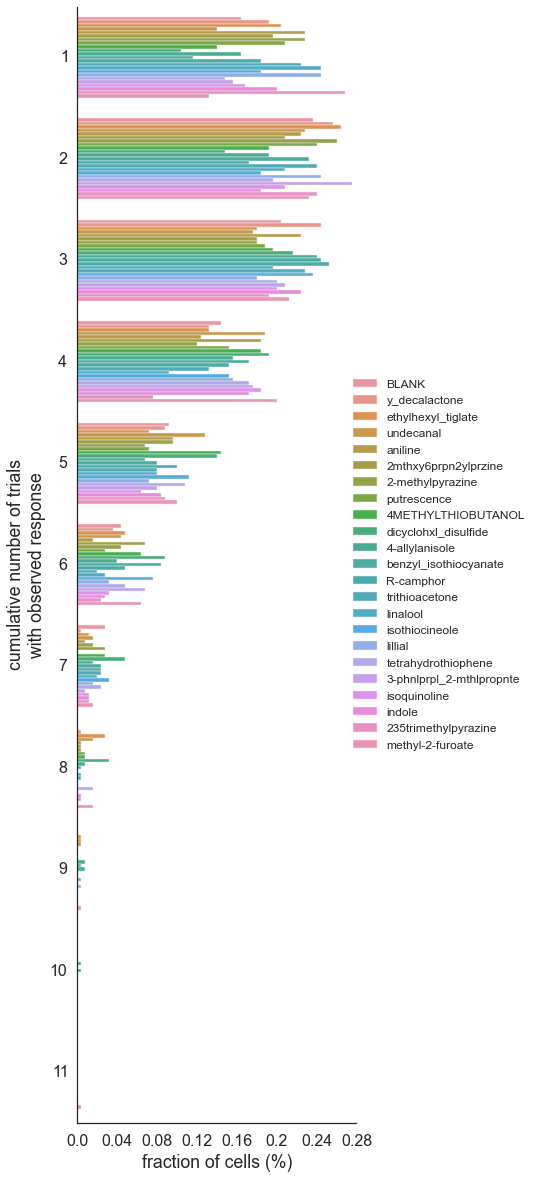

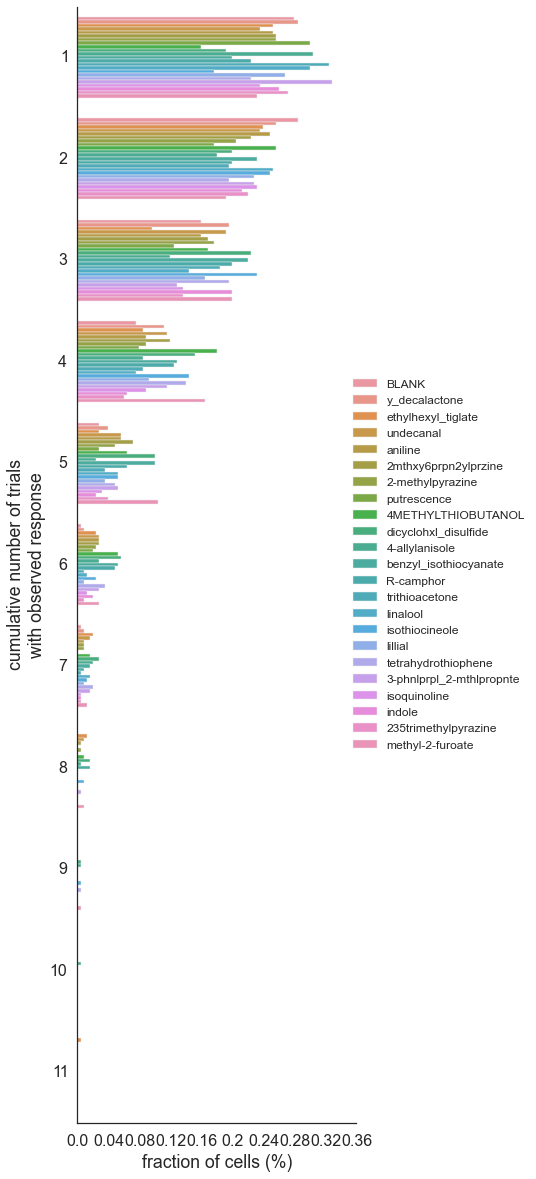

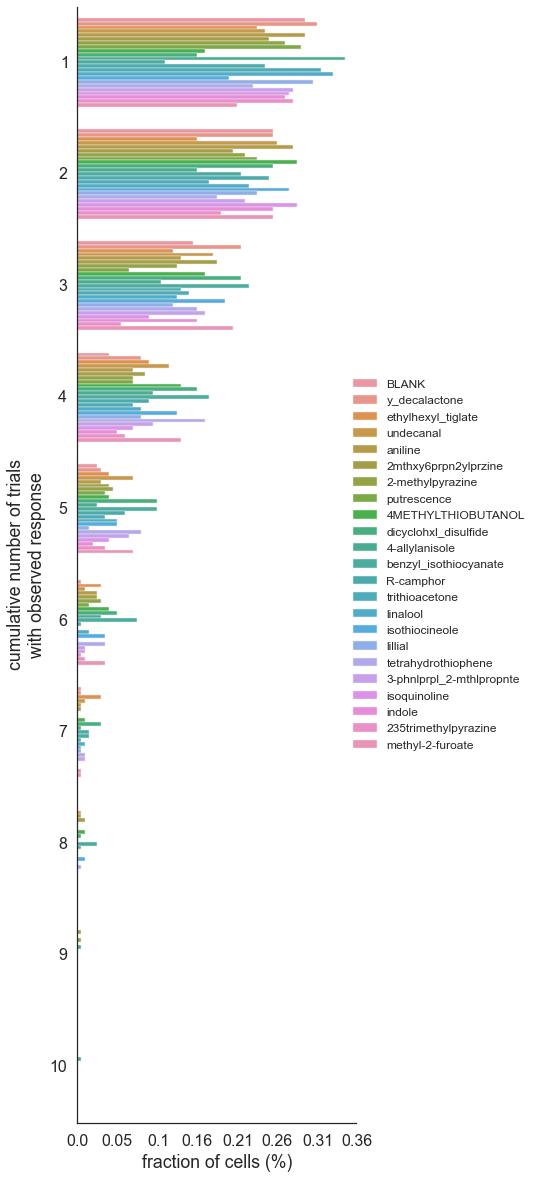

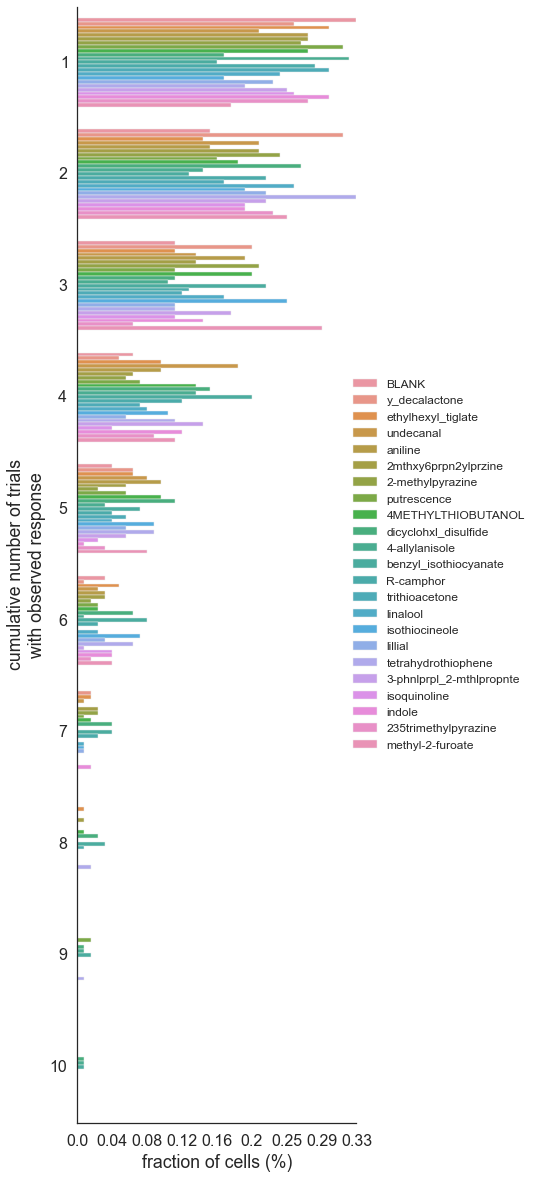

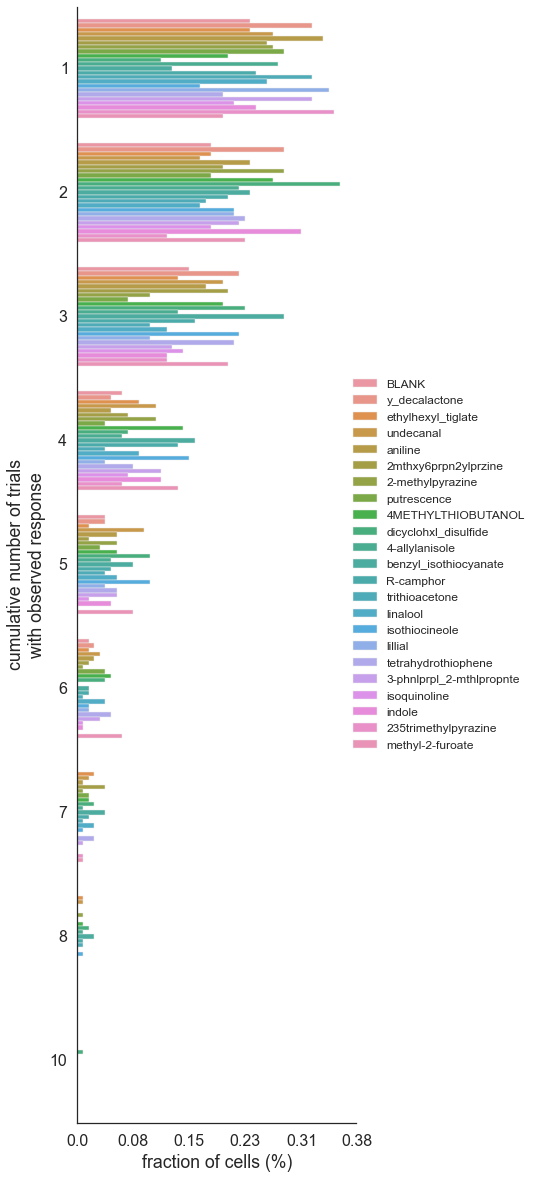

In [4]:
#input
# things that change with experiment
experiment = 'sp062817a'
epoch_ = 1

#paths

basedir = '/Users/Stan/Desktop/'#'/Volumes/G-DRIVE PRO Thunderbolt/2017/'
h5dir = basedir + 'h5/'
qcGitDir = '/Users/Stan/Documents/myPiriform/notebooks/qc/{0}/'.format(experiment)
odorInfoPath = basedir + '{0}/odorInfo_e1.dat'.format(experiment)
odorNamesCSV = basedir + '{}/e1_odor_order_odorlist.csv'.format(experiment)

#no classes in experiment 3
# classes = dict(esters = [1,2,3,4,5],
#                 aldehydes = [6,7,8,9,10],
#                 ketones = [11,12,13,14,15,16],
#                 acids = [17,18,19,20,21,22])

#read in information that doesn't depend on slice_
odorNames = pd.DataFrame.from_csv(odorNamesCSV)
odorNames.index.name = 'odorID'
odor_info = pickle.load(open(odorInfoPath))['epoch1']

#########################################################################################################################
#the rest changes with slice_

for slice_ in [0,1,2,3,4]:

    #paths
    sframePath = basedir + '{0}/sframe_slice_{1}_processed'.format(experiment, slice_)
    tifPath = basedir + '{0}/aligned/green/slice_{1}/'.format(experiment, slice_)
    workflowDictPath = basedir + '{0}/workflow_dict_e1_slice{1}.dat'.format(experiment, slice_)

    metadataPath = basedir + '{0}/metadata/slice_{1}/{0}_e1_002_015_slice_{1}_channel_0.dat'.format(experiment, slice_)

    #read in previously made workflowDIct
    workflow_dict = pickle.load(open(workflowDictPath))

    from spUtils.FindSigResponses.sigTesting import getcellsBasic
    numOdors = workflow_dict['numOdors']
    numCells = workflow_dict['numCells']
    numTrials = workflow_dict['numTrials']
    normed_traces=workflow_dict['normed_traces']['corrected_rois']
    window = 16 #frames... 2 seconds. 
    responseDict = defaultdict(dict)

    for cell in range(numCells):
        for odor in range(numOdors):               
            responseDict[odor][cell] =  [trial for trial in getcellsBasic(workflow_dict, normed_traces, odor, cell, numTrials, window)]        

    #report number of trials (and identity) on which a response is detected. Typically 50% of trials for trial_thresh
    #tune to 10% population response on null. 
    trial_thresh = 1
    def filterSigCells(responseDict, odor, trial_thresh = trial_thresh):
        for cell, numTrials in responseDict[odor].items():
            if len(numTrials)>=trial_thresh:

                yield cell, numTrials


    ResponsiveCellsbyOdor = {odor:{cell:numTrials for cell, numTrials in filterSigCells(responseDict, odor, trial_thresh)} for odor in range(numOdors)}# changwe range for new setup


    allDFs = []
    for odor in range(23):

        numResponsesByCell = [(cell, len(numTrials)) for cell, numTrials in filterSigCells(responseDict, odor=odor, trial_thresh = 1)]

        alist = []
        blist = []
        for a, b in numResponsesByCell:
            alist.append(a)
            blist.append(b)

        numTrialsDf = pd.DataFrame(blist).rename(columns = {0:'count'})
        cellsDf = pd.DataFrame(alist).rename(columns = {0:'cellID'})

        toplot = pd.concat([cellsDf,numTrialsDf],axis = 1)
        toplot['numCells'] = numCells
        toplot['odorID'] = odorNames.iloc[odor]['name']#odor
        allDFs.append(toplot)
    toplot = pd.concat(allDFs)

#     cmap = ['b', 'g', 'r', 'y', 'm', 'c']
#     pal = {}
#     pal[odorNames.iloc[0]['name']] = 'k'
#     for i in range(23):
#         #print i,odorNames.iloc[i]['name']
#         for j, (class_, idx) in enumerate(classes.items()):
#             if i in idx:
#                 pal[odorNames.iloc[i]['name']] = cmap[j]



    fig, ax = plt.subplots(1,1, figsize = (5,20))
    ax = sns.countplot(y = 'count', hue = 'odorID',data = toplot) #, palette = pal
    ax.legend(loc = 'center left', bbox_to_anchor=(.95, 0.5), fontsize = 12, markerscale = .5)
    sns.despine()
    plt.ylabel('cumulative number of trials \nwith observed response')
    plt.xlabel('fraction of cells (%)')
    #plt.xticks(np.linspace(0,60,7, endpoint = True))
    ticks = ax.get_xticks()
    ax.set_xticklabels(np.round(np.linspace(ticks[0],ticks[-1],ticks.shape[0], endpoint = True)/numCells,2));
    plt.savefig(qcGitDir + 'CumTrialsWithResponseByOdor_{}.png'.format(slice_), dpi = 300, bbox_inches = 'tight', pad_inches = 0.5)
    print 'slice {} complete'.format(slice_)